In [55]:
import pandas as pd
import sklearn.metrics as metr
import numpy as np
#from ignite.metrics import Precision
import torch
from torchvision import models
import os
import time
from sklearn.metrics import multilabel_confusion_matrix
import random

In [86]:
m = models.resnet50(pretrained=True)
for param in m.parameters():
    param.requires_grad = False
input_num = 3
out_shape = 2
m.conv1 = torch.nn.Conv2d(input_num, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
last_layer_in_channels = m.fc.in_features
m.fc = torch.nn.Linear(last_layer_in_channels, out_shape)

In [87]:
device = 'cuda'
model_path = '../Saved_models/'
model_name = 'Saved_models'
model = m
model.load_state_dict(torch.load(model_path+model_name))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [81]:
class Metrics():
    
    def __init__(self):
        
        self.tp = 0
        self.fp = 0
        self.fn = 0
        self.tn = 0
        
    def update(self, y_true, y_pred):
        tn, fp, fn, tp = metr.confusion_matrix(y_true, y_pred).ravel()
        self.tp += tp
        self.fp += fp
        self.fn += fn
        self.tn += tn
        
    def compute(self):
        acc = (self.tp + self.tn) / (self.tp + self.tn + self.fp + self.fn) # TP + TN / (TP + TN + FP + FN)
        prec = self.tp / (self.tp + self.fp)                                # TP / (TP + FP)
        rec = self.tp / (self.tp + self.fn)                                 # TP / (TP + FN)
        f1 = 2 * prec * rec / (rec + prec)                                  # 2 * PREC * REC / (PREC + REC)
        return acc, prec, rec, f1
    
    def reset(self):
        self.tp = 0
        self.fp = 0
        self.fn = 0
        self.tn = 0
        

In [83]:
M = Metrics()
M.update(y.ravel(), y_pred.ravel())
print(M.compute())
M.reset()
print(M.tp, M.fp)

(0.75, 0.5, 1.0, 0.6666666666666666)
0 0


In [97]:

#### здесь как предсказывал ignite
train_test_id = pd.read_csv('../Data/train_test_id.csv')
mask_ind = pd.read_csv('../Data/mask_ind.csv')
metric = Metrics()
args = {
    'image_path': '../Data/h5/',
    'attribute':['attribute_pigment_network', 'attribute_milia_like_cyst'],
    'mask_use':False,
    'batch_size': 2
}
loader = make_loader(train_test_id, mask_ind, args, train='valid', shuffle=True)
for i, (image_batch, labels_batch, names) in enumerate(loader):
    image_batch = image_batch.permute(0, 3, 1, 2).to(device).type(torch.cuda.FloatTensor)
    labels_batch = labels_batch.to(device).type(torch.cuda.FloatTensor)
    output_probs = model(image_batch)
    outputs = torch.sigmoid(output_probs)

    print(labels_batch.data.cpu().numpy().ravel(), np.around(outputs.data.cpu().numpy().ravel()))
    
    metric.update(labels_batch.data.cpu().numpy().ravel(), np.around(outputs.data.cpu().numpy().ravel()))
    metrics = metric.compute()
    print('Acc: {:.4f} Prec: {:.4f} Recall: {:.4f}'.format(
            metrics[0], metrics[1], metrics[2]))
metric.reset()

[0. 1. 0. 1.] [0. 1. 0. 1.]
Acc: 1.0000 Prec: 1.0000 Recall: 1.0000
[0. 1. 0. 1.] [0. 1. 0. 1.]
Acc: 1.0000 Prec: 1.0000 Recall: 1.0000
[0. 1. 0. 1.] [0. 1. 0. 1.]
Acc: 1.0000 Prec: 1.0000 Recall: 1.0000
[0. 0. 0. 0.] [0. 1. 0. 1.]
Acc: 0.8750 Prec: 0.7500 Recall: 1.0000
[0. 1. 1. 1.] [0. 1. 0. 1.]
Acc: 0.8500 Prec: 0.8000 Recall: 0.8889
[0. 0. 0. 1.] [0. 1. 0. 1.]
Acc: 0.8333 Prec: 0.7500 Recall: 0.9000
[0. 0. 0. 1.] [0. 1. 0. 1.]
Acc: 0.8214 Prec: 0.7143 Recall: 0.9091
[1. 0. 0. 0.] [0. 1. 0. 1.]
Acc: 0.7500 Prec: 0.6250 Recall: 0.8333
[0. 1. 0. 1.] [0. 1. 0. 1.]
Acc: 0.7778 Prec: 0.6667 Recall: 0.8571
[0. 0. 0. 0.] [0. 1. 0. 1.]
Acc: 0.7500 Prec: 0.6000 Recall: 0.8571
[0. 1. 0. 0.] [0. 1. 0. 1.]
Acc: 0.7500 Prec: 0.5909 Recall: 0.8667
[1. 0. 0. 0.] [0. 1. 0. 1.]
Acc: 0.7083 Prec: 0.5417 Recall: 0.8125
[0. 1. 1. 1.] [0. 1. 0. 1.]
Acc: 0.7115 Prec: 0.5769 Recall: 0.7895
[0. 0. 0. 1.] [0. 1. 0. 1.]
Acc: 0.7143 Prec: 0.5714 Recall: 0.8000
[0. 0. 0. 1.] [0. 1. 0. 1.]
Acc: 0.7167 Prec: 0.

[1. 0. 0. 0.] [0. 1. 0. 1.]
Acc: 0.6789 Prec: 0.5894 Recall: 0.7178
[0. 0. 0. 1.] [0. 1. 0. 1.]
Acc: 0.6794 Prec: 0.5887 Recall: 0.7192
[0. 1. 1. 0.] [0. 1. 0. 1.]
Acc: 0.6780 Prec: 0.5880 Recall: 0.7171
[0. 1. 0. 0.] [0. 1. 0. 1.]
Acc: 0.6786 Prec: 0.5873 Recall: 0.7184
[1. 1. 0. 1.] [0. 1. 0. 1.]
Acc: 0.6791 Prec: 0.5906 Recall: 0.7177
[0. 1. 1. 0.] [0. 1. 0. 1.]
Acc: 0.6777 Prec: 0.5898 Recall: 0.7156
[0. 0. 0. 0.] [0. 1. 0. 1.]
Acc: 0.6764 Prec: 0.5853 Recall: 0.7156
[1. 0. 0. 0.] [0. 1. 0. 1.]
Acc: 0.6731 Prec: 0.5808 Recall: 0.7123
[0. 1. 0. 1.] [0. 1. 0. 1.]
Acc: 0.6756 Prec: 0.5840 Recall: 0.7150
[0. 1. 0. 1.] [0. 1. 0. 1.]
Acc: 0.6780 Prec: 0.5871 Recall: 0.7176
[0. 1. 1. 1.] [0. 1. 0. 1.]
Acc: 0.6786 Prec: 0.5902 Recall: 0.7169
[0. 1. 0. 0.] [0. 1. 0. 1.]
Acc: 0.6791 Prec: 0.5896 Recall: 0.7182
[0. 0. 0. 1.] [0. 1. 0. 1.]
Acc: 0.6796 Prec: 0.5889 Recall: 0.7195
[0. 0. 0. 1.] [0. 1. 0. 1.]
Acc: 0.6801 Prec: 0.5882 Recall: 0.7207
[0. 1. 0. 0.] [0. 1. 0. 1.]
Acc: 0.6807 Prec: 0.

# Data

In [13]:
path = '../Data/'
tti_name = 'train_test_id.csv'
mi_name = 'mask_ind.csv'
os.listdir('../Data/')

['h5', 'train_test_id.csv', 'skin_images', 'mask_ind.csv', 'skin_masks']

In [11]:
tti = pd.read_csv(path+tti_name)
tti.head()

,ID,Split
0,ISIC_0000000,train
1,ISIC_0000001,train
2,ISIC_0000003,train
3,ISIC_0000004,train
4,ISIC_0000006,train


In [14]:
mi = pd.read_csv(path+mi_name)
mi.head()

,globules,milia_like_cyst,negative_network,pigment_network,streaks
0,0,0,0,1,0
1,1,0,0,1,1
2,0,1,0,1,0
3,0,0,0,0,0
4,0,0,0,1,0


# Test step

In [2]:
import os
import pandas as pd
import sys
sys.path.insert(0, '../')
from train import make_step
from models import create_model
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.backends import cudnn
import torch
from metrics import Metrics
from loss import LossBinary

Using TensorFlow backend.


ImportError: cannot import name 'LossBinary'

In [ ]:
class Args:
    
    def __init__(self):
        self.attribute = ['attribute_milia_like_cyst', 'attribute_pigment_network']
        self.pretrained = True
        self.jaccard_weight = 0.
        self.show_model = True
        self.mask_use = True
        self.freezing = True
        self.prob = 0.1
        self.image_path = '../Data/h5/'
        self.batch_size = 2
        self.model = 'resnet50'
        self.lr = 0.00001
        self.augment_list = []
        self.N = 0
device = 'cuda'

In [53]:
args = Args()
train_test_id = pd.read_csv('../Data/train_test_id.csv')
mask_ind = pd.read_csv('../Data/mask_ind.csv')

In [54]:
cudnn.benchmark = True
torch.set_default_tensor_type(torch.cuda.FloatTensor)
model, optimizer = create_model(args, device)
metric = Metrics()
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.8, patience=10, verbose=True)
criterion = LossBinary(args.jaccard_weight)
metric = Metrics()
print(model)

ResNet(
  (conv1): Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [55]:
mode = 'train'
ep = 0
results = pd.DataFrame(columns=['mask_use', 'freeze_mode', 'lr', 'exp', 'train_mode', 'epoch', 'loss', 'prec',
                                    'recall'])
metrics, results = make_step(model=model, mode=mode, train_test_id=train_test_id, mask_ind=mask_ind,
                                                args=args, device=device, criterion=criterion, optimizer=optimizer,
                                                results=results, metric=metric, epoch=ep, scheduler=scheduler)

Epoch: 0 Loss: 0.168882 Accuracy: 0.8636 Precision: 0.8715 Recall: 0.8940 F1: 0.8826 Time: 113.1284


In [56]:
mode = 'valid'
ep = 0
results = pd.DataFrame(columns=['mask_use', 'freeze_mode', 'lr', 'exp', 'train_mode', 'epoch', 'loss', 'prec',
                                    'recall'])
metrics, results = make_step(model=model, mode=mode, train_test_id=train_test_id, mask_ind=mask_ind,
                                                args=args, device=device, criterion=criterion, optimizer=optimizer,
                                                results=results, metric=metric, epoch=ep, scheduler=scheduler)

Epoch: 0 Loss: 0.683116 Accuracy: 0.6617 Precision: 0.7229 Recall: 0.6838 F1: 0.7028 Time: 5.5147


In [4]:
mask = np.array([[0,1,2],
                 [3,4,5],
                 [6,7,8]])
mask[2:,2:].fill(0.)
print(mask)

[[0 1 2]
 [3 4 5]
 [6 7 0]]


# Test step

In [7]:
import os
import pandas as pd
import sys
sys.path.insert(0, '../')
from train import make_step
from models import create_model
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.backends import cudnn
import torch
from metrics import Metrics
from loss import LossBinary

ImportError: cannot import name 'LossBinary'

In [52]:
class Args:
    
    def __init__(self):
        self.attribute = ['attribute_milia_like_cyst', 'attribute_pigment_network']
        self.pretrained = True
        self.jaccard_weight = 0.
        self.show_model = True
        self.mask_use = True
        self.freezing = True
        self.prob = 0.1
        self.image_path = '../Data/h5/'
        self.batch_size = 2
        self.model = 'resnet50'
        self.lr = 0.00001
        self.augment_list = []
        self.N = 0
device = 'cuda'

In [53]:
args = Args()
train_test_id = pd.read_csv('../Data/train_test_id.csv')
mask_ind = pd.read_csv('../Data/mask_ind.csv')

In [54]:
cudnn.benchmark = True
torch.set_default_tensor_type(torch.cuda.FloatTensor)
model, optimizer = create_model(args, device)
metric = Metrics()
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.8, patience=10, verbose=True)
criterion = LossBinary(args.jaccard_weight)
metric = Metrics()
print(model)

ResNet(
  (conv1): Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [55]:
mode = 'train'
ep = 0
results = pd.DataFrame(columns=['mask_use', 'freeze_mode', 'lr', 'exp', 'train_mode', 'epoch', 'loss', 'prec',
                                    'recall'])
metrics, results = make_step(model=model, mode=mode, train_test_id=train_test_id, mask_ind=mask_ind,
                                                args=args, device=device, criterion=criterion, optimizer=optimizer,
                                                results=results, metric=metric, epoch=ep, scheduler=scheduler)

Epoch: 0 Loss: 0.168882 Accuracy: 0.8636 Precision: 0.8715 Recall: 0.8940 F1: 0.8826 Time: 113.1284


In [56]:
mode = 'valid'
ep = 0
results = pd.DataFrame(columns=['mask_use', 'freeze_mode', 'lr', 'exp', 'train_mode', 'epoch', 'loss', 'prec',
                                    'recall'])
metrics, results = make_step(model=model, mode=mode, train_test_id=train_test_id, mask_ind=mask_ind,
                                                args=args, device=device, criterion=criterion, optimizer=optimizer,
                                                results=results, metric=metric, epoch=ep, scheduler=scheduler)

Epoch: 0 Loss: 0.683116 Accuracy: 0.6617 Precision: 0.7229 Recall: 0.6838 F1: 0.7028 Time: 5.5147


In [3]:
MSE = torch.nn.MSELoss()
t1 = torch.Tensor([1,2,3])
t2 = torch.Tensor([1.2,2.2,3.2])
res = MSE(t1,t2)
print(res)

tensor(0.0400)


In [5]:
MSE2 = torch.nn.MSELoss(reduction='sum')
res2 = MSE2(t1,t2)
print(res2)

tensor(0.1200)


# Loader

In [2]:
import os
import torchvision.transforms.functional as TF
from keras.preprocessing.image import array_to_img, img_to_array
from torch.utils.data import Dataset, DataLoader
import random
import numpy as np
import torch
import h5py
from torch.optim.lr_scheduler import ReduceLROnPlateau


def load_image(file_name, type='image'):
    f = h5py.File(file_name, 'r')
    file_np = f['img'][()]
    if type == 'image':
        file_np = (file_np / 255.0).astype('float32')
    elif type == 'mask':
        file_np = file_np.astype('uint8')
    else:
        print('not choosed type to load')
        return
    return file_np


class MyDataset(Dataset):

    def __init__(self, train_test_id, labels_ids, args, train):

        self.train_test_id = train_test_id
        self.labels_ids = labels_ids
        self.image_path = args.image_path
        self.pretrained = args.pretrained
        self.attribute = args.attribute
        self.mask_use = args.mask_use
        self.augment_list = args.augment_list
        self.prob = args.prob
        self.train = train
        self.all_attributes = ['attribute_globules', 'attribute_milia_like_cyst', 'attribute_negative_network',
                               'attribute_pigment_network', 'attribute_streaks']

        self.indexes = [i for i, val in enumerate(self.all_attributes) for attr in self.attribute if attr == val]
        self.cell = args.cell
        self.cell_size = args.cell_size

        if train == 'train':
            self.labels_ids = self.labels_ids[self.train_test_id['Split'] == 'train'].values.astype('uint8')
            self.train_test_id = self.train_test_id[self.train_test_id['Split'] == 'train'].ID.values
            #print('Train =', self.train, 'train_test_id.shape: ', self.train_test_id.shape)
        elif train == 'valid':
            self.labels_ids = self.labels_ids[self.train_test_id['Split'] != 'train'].values.astype('uint8')
            self.train_test_id = self.train_test_id[self.train_test_id['Split'] != 'train'].ID.values
            #print('Train =', self.train, 'train_test_id.shape: ', self.train_test_id.shape)

        self.n = self.train_test_id.shape[0]

    def __len__(self):
        return self.n

    def transform_fn(self, image, mask):

        image = array_to_img(image, data_format="channels_last")
        mask_pil_array = [None] * mask.shape[-1]
        for i in range(mask.shape[-1]):
            mask_pil_array[i] = array_to_img(mask[:, :, i, np.newaxis], data_format="channels_last")
        if 'hflip' in self.augment_list:
            if random.random() > 0.5:
                image = TF.hflip(image)
                for i in range(mask.shape[-1]):
                    mask_pil_array[i] = TF.hflip(mask_pil_array[i])
        if 'vflip' in self.augment_list:
            if random.random() > 0.5:
                image = TF.vflip(image)
                for i in range(mask.shape[-1]):
                    mask_pil_array[i] = TF.vflip(mask_pil_array[i])
        if 'affine' in self.augment_list:
            angle = random.randint(0, 90)
            translate = (random.uniform(0, 100), random.uniform(0, 100))
            scale = random.uniform(0.5, 2)
            image = TF.affine(image, angle, translate, scale)
            for i in range(mask.shape[-1]):
                mask_pil_array[i] = TF.affine(mask_pil_array[i], angle, translate, scale)
        if 'adjust_brightness' in self.augment_list:
            if random.random() > 0.3:
                brightness_factor = random.uniform(0.8, 1.2)
                image = TF.adjust_brightness(image, brightness_factor)
        if 'adjust_saturation' in self.augment_list:
            if random.random() > 0.3:
                saturation_factor = random.uniform(0.8, 1.2)
                image = TF.adjust_saturation(image, saturation_factor)

        image = img_to_array(image, data_format="channels_last")
        if self.mask_use:
            for i in range(mask.shape[-1]):
                mask[:, :, i] = img_to_array(mask_pil_array[i], data_format="channels_last")[:, :, 0].astype('uint8')

        image = (image / 255.0).astype('float32')
        mask = (mask / 255.0).astype('uint8')

        if self.pretrained:
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            image = (image - mean)/std

        return image, mask

    def __getitem__(self, index):

        name = self.train_test_id[index]
        path = self.image_path
        # Load image and from h5
        image = load_image(os.path.join(path, '%s.h5' % name), 'image')
        mask = np.empty([image.shape[0], image.shape[1], len(self.attribute)])
        if self.mask_use:
            for i, attr in enumerate(self.attribute):
                mask[:, :, i] = load_image(os.path.join(path, '{}_{}.h5'.format(name, attr)), 'mask')[:, :, 0]
        else:
            mask = image

        if self.train == 'train':
            if self.augment_list:
                image, mask = self.transform_fn(image, mask)
        """fig = plt.figure(figsize=(5, 5))
        ax = []
        for channel in range(mask.shape[2]):
            im = mask[:, :, channel]
            ax.append(fig.add_subplot(2, mask.shape[2], channel + 1))
            ax[channel].set_title(name[5:]+str(np.unique(im)))
            plt.imshow(im)
        print(np.unique(mask))"""
        if self.mask_use:
            p = np.random.uniform(0, 1)
            if self.train == 'valid':
                mask.fill(0.)
            elif self.cell:
                for i in range(0, image.shape[0], self.cell_size):
                    for j in range(0, image.shape[0], self.cell_size):
                        p = np.random.uniform(0, 1)
                        if p < self.prob:
                            mask[i:i+self.cell_size, j:j+self.cell_size, :].fill(0.)
            else:
                if p < self.prob:
                    mask.fill(0.)
            image_with_mask = np.dstack((image, mask))
        else:
            image_with_mask = image

        """for channel in range(mask.shape[2]):
            im = mask[:, :, channel]
            ax.append(fig.add_subplot(2, mask.shape[2], mask.shape[2] + channel + 1))
            ax[mask.shape[2] + channel].set_title(name[5:]+str(np.unique(im)))
            plt.imshow(im)
        plt.show()"""
        labels = np.array([self.labels_ids[index, ind] for ind in self.indexes])
        
        return np.array([image_with_mask for i in range(3)]), np.array([labels for i in range(3)]), name


def make_loader(train_test_id, labels_ids, args, train=True, shuffle=True):

    data_set = MyDataset(train_test_id=train_test_id,
                         labels_ids=labels_ids,
                         args=args,
                         train=train)
    data_loader = DataLoader(data_set,
                             batch_size=args.batch_size,
                             shuffle=shuffle,
                             num_workers=args.workers,
                             pin_memory=torch.cuda.is_available()
                             )
    return data_loader

Using TensorFlow backend.


In [3]:
class Args:
    
    def __init__(self):
        self.attribute = ['attribute_milia_like_cyst', 'attribute_pigment_network']
        self.pretrained = True
        self.show_model = True
        self.mask_use = True
        self.freezing = True
        self.prob = 0.1
        self.image_path = '/home/irek/PycharmProjects/Data/h5/'
        self.batch_size = 1
        self.model = 'resnet50'
        self.lr = 0.00001
        self.augment_list = []
        self.N = 0
        self.cell = True
        self.cell_size = 28
        self.workers = 1
device = 'cuda'

In [4]:
args = Args()
train_test_id = pd.read_csv('../Data/train_test_id.csv')
mask_ind = pd.read_csv('../Data/mask_ind.csv')
mode = 'train'
loader = make_loader(train_test_id, mask_ind, args, train=mode, shuffle=True)    

In [5]:
from torchvision.models.resnet import Bottleneck, model_urls, _resnet, conv1x1, conv3x3
from torchvision.models.utils import load_state_dict_from_url
from torch.optim import Adam
from torch import nn

In [6]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        y = self.layer2(x)
        x = self.layer3(y)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x, y

    def forward(self, x):
        return self._forward_impl(x)
    
def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

In [7]:
model = _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained=False, progress=True)
if args.mask_use:
    input_num = 3 + len(args.attribute)
    out_shape = len(args.attribute)
else:
    input_num = 3
    out_shape = len(args.attribute)
model.conv1 = torch.nn.Conv2d(input_num, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
last_layer_in_channels = model.fc.in_features
model.fc = torch.nn.Linear(last_layer_in_channels, out_shape)
model.to(device)
optimizer = Adam(model.parameters(), lr=args.lr, weight_decay=0.01)

In [8]:
from sklearn.metrics import confusion_matrix


class Metrics:

    def __init__(self):
        self.tp = 0
        self.fp = 0
        self.fn = 0
        self.tn = 0

    def update(self, y_true, y_pred):

        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[1, 0]).ravel()
        self.tp += tp
        self.fp += fp
        self.fn += fn
        self.tn += tn

    def compute(self, loss, ep, epoch_time):
        acc = (self.tp + self.tn) / (self.tp + self.tn + self.fp + self.fn)  # TP + TN / (TP + TN + FP + FN)
        prec = self.tp / (self.tp + self.fp)  # TP / (TP + FP)
        rec = self.tp / (self.tp + self.fn)  # TP / (TP + FN)
        f1 = 2 * prec * rec / (rec + prec)  # 2 * PREC * REC / (PREC + REC)
        return {
                    'epoch': ep,
                    'loss': loss.item(),
                    'epoch_time': epoch_time,
                    'accuracy': acc,
                    'precision': prec,
                    'recall' : rec,
                    'f1_score': f1
                }

    def reset(self):
        self.tp = 0
        self.fp = 0
        self.fn = 0
        self.tn = 0

In [9]:
#torch.cuda.empty_cache()

In [10]:
metric = Metrics()

In [26]:
nll_loss = torch.nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([0.5, 1.0]).to(device))

for i, (image_batch, labels_batch, names) in enumerate(loader):
    #print(names)
    #print(image_batch[0].shape, labels_batch[0].shape, 'batch')
    aux_output, last_output = [0,0], [0,0]
    loss1 = 0
    loss2 = 0

    im = image_batch[0].permute(0, 3, 1, 2).to(device).type(torch.cuda.FloatTensor)
    lab = labels_batch[0].to(device).type(torch.cuda.FloatTensor)
    
    last_output, aux_output = model(im)
    
    if isinstance(args.attribute, str):
        labels_batch = torch.reshape(lab, (-1, 1))

    loss1 = nll_loss(last_output, lab)
    #print(aux_output.std(dim=0))
    l = aux_output.std(dim=0).data
    
    loss2 = torch.sum(l)
    #print(loss2, 'loss')
    
    if mode == 'train':
        optimizer.zero_grad()
        loss = loss1 + loss2
        loss.backward()
        optimizer.step()
    
        outputs = torch.sigmoid(last_output)

        outputs = np.around(outputs.data.cpu().numpy().ravel())
        labels_batch = labels_batch.data.cpu().numpy().ravel()
        metric.update(labels_batch, outputs)
    

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [9]:
nll_loss = torch.nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([0.5, 1.0]).to(device))

def make_step(model, mode, train_test_id, mask_ind, args, device, optimizer, results, metric, epoch,
              scheduler):
    start_time = time.time()
    loader = make_loader(train_test_id, mask_ind, args, train=mode, shuffle=True)
    n = len(loader)
    if mode == 'valid':
        torch.set_grad_enabled(False)
    for i, (image_batch, labels_batch, names) in enumerate(loader):
        if i == n - 1:
            print(f'\r', end='')
        elif i < n - 3:
            print(f'\rBatch {i} / {n} ', end='')
        """if i < 5 :
            fig = plt.figure(figsize=(10, 10))
            ax = []
            for i, image in enumerate(image_batch):
                for channel in range(3, image.shape[2]):
                    im = image.cpu().numpy()[:, :, channel]
                    ax.append(fig.add_subplot(len(image_batch), image.shape[2], i*(image.shape[2]-3)+channel-3 + 1))
                    ax[i*(image.shape[2]-3)+channel-3].set_title(str(np.unique(im))) #names[i][5:]+
                    plt.imshow(im)
            plt.show()"""
        image_batch = image_batch[0].permute(0, 3, 1, 2).to(device).type(torch.cuda.FloatTensor)
        labels_batch = labels_batch[0].to(device).type(torch.cuda.FloatTensor)
        last_output, aux_output = model(image_batch)

        if isinstance(args.attribute, str):
            labels_batch = torch.reshape(labels_batch, (-1, 1))

        loss1 = nll_loss(last_output, labels_batch)
        #print(aux_output.std(dim=0))
        l = aux_output.std(dim=0).data

        loss2 = torch.sum(l)
        loss = loss1 + loss2
        if mode == 'train':
            optimizer.zero_grad()
                 
            loss.backward()
            optimizer.step()

        outputs = torch.sigmoid(last_output)

        outputs = np.around(outputs.data.cpu().numpy().ravel())
        labels_batch = labels_batch.data.cpu().numpy().ravel()
        metric.update(labels_batch, outputs)

    epoch_time = time.time() - start_time

    metrics = metric.compute(loss, epoch, epoch_time)

    if mode == 'valid':
        torch.set_grad_enabled(True)
        scheduler.step(loss)

    print('Epoch: {} Loss: {:.6f} Accuracy: {:.4f} Precision: {:.4f} Recall: {:.4f} F1: {:.4f} Time: {:.4f}'.format(
        metrics['epoch'],
        metrics['loss'],
        metrics['accuracy'],
        metrics['precision'],
        metrics['recall'],
        metrics['f1_score'],
        metrics['epoch_time']))

    metric.reset()

    return metrics, results


In [11]:
results = 0
ep = 0
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.8, patience=10, verbose=True)
metrics = [0,0]
metric = Metrics()
for i, mode in enumerate(['train', 'valid']):

    metrics[i], results = make_step(model=model, mode=mode, train_test_id=train_test_id, mask_ind=mask_ind,
                                    args=args, device=device, optimizer=optimizer,
                                    results=results, metric=metric, epoch=ep, scheduler=scheduler)

Epoch: 0 Loss: 0.741835 Accuracy: 0.7121 Precision: 0.7386 Recall: 0.7709 F1: 0.7544 Time: 195.0346
Epoch: 0 Loss: 0.412552 Accuracy: 0.6717 Precision: 0.7005 Recall: 0.7664 F1: 0.7320 Time: 6.6408


In [3]:
tt = torch.Tensor([[[0, 1, 2],
                    [3, 4, 5],
                    [6, 7, 8],
                    [9,10,11]],
                   [[12,13,14],
                    [15,16,17],
                    [18,19,20],
                    [21,22,23]]])
tt.shape

torch.Size([2, 4, 3])

In [9]:
for i in range(2):
    print(tt[i])   # std

tensor([[ 0.,  1.,  2.],
        [ 3.,  4.,  5.],
        [ 6.,  7.,  8.],
        [ 9., 10., 11.]])
tensor([[12., 13., 14.],
        [15., 16., 17.],
        [18., 19., 20.],
        [21., 22., 23.]])


In [11]:
for i in range(4):
    print(tt[:,i,:]) # binary

tensor([[ 0.,  1.,  2.],
        [12., 13., 14.]])
tensor([[ 3.,  4.,  5.],
        [15., 16., 17.]])
tensor([[ 6.,  7.,  8.],
        [18., 19., 20.]])
tensor([[ 9., 10., 11.],
        [21., 22., 23.]])


In [7]:
tt[0]

tensor([[ 0.,  1.,  2.],
        [ 3.,  4.,  5.],
        [ 6.,  7.,  8.],
        [ 9., 10., 11.]])

In [18]:
a = tt.view((-1, tt.shape[1:]))

TypeError: view(): argument 'size' must be tuple of ints, but found element of type torch.Size at pos 2

In [27]:
tt.size([1:])

SyntaxError: invalid syntax (<ipython-input-27-f61dc055c0ce>, line 1)

In [30]:
a = tt.reshape((-1, *tt.shape[-1:]))

In [31]:
a

tensor([[ 0.,  1.,  2.],
        [ 3.,  4.,  5.],
        [ 6.,  7.,  8.],
        [ 9., 10., 11.],
        [12., 13., 14.],
        [15., 16., 17.],
        [18., 19., 20.],
        [21., 22., 23.]])

In [15]:
tt.shape[-2:]

torch.Size([4, 3])

In [6]:
tt.view(-1, 3)

tensor([[ 0.,  1.,  2.],
        [ 3.,  4.,  5.],
        [ 6.,  7.,  8.],
        [ 9., 10., 11.],
        [12., 13., 14.],
        [15., 16., 17.],
        [18., 19., 20.],
        [21., 22., 23.]])

In [8]:
tt.view(-1, 3)[:4]

tensor([[ 0.,  1.,  2.],
        [ 3.,  4.,  5.],
        [ 6.,  7.,  8.],
        [ 9., 10., 11.]])

In [ ]:
batch = (b, a, h, w, c)

In [9]:
torch.nonzero(y_true, y_pred)

TypeError: nonzero() takes from 2 to 1 positional arguments but 2 were given

In [8]:
multilabel_confusion_matrix(y_true, y_pred, labels=[0,1])

array([[[1, 3],
        [0, 0]],

       [[1, 1],
        [1, 1]]], dtype=int64)

In [26]:
class Args:
    def __init__(self):
        self.attribute = ['0', '1']

args = Args()

class Metrics:

    def __init__(self, args):
        self.conf_matrix = np.zeros([len(args.attribute), 2, 2])
        self.loss = []
        self.bce_loss = []
        self.std_loss = []

    def update(self, y_true, y_pred, loss=0, bce_loss=0, std_loss=0):
        self.conf_matrix += multilabel_confusion_matrix(y_true, y_pred, labels=[0,1])
        self.loss.append(loss)
        self.bce_loss.append(bce_loss)
        self.std_loss.append(std_loss)

    def compute(self, ep=0, epoch_time=0):

        acc_l = []
        prec_l =[]
        rec_l = []
        f1_l  = []
        for cm in self.conf_matrix:
            tn, fp, fn, tp = cm.ravel()
            acc_l.append((tp + tn) / (tp + tn + fp + fn))          # TP+TN/(TP+TN+FP+FN)
            p = tp / (tp + fp + 1e-15)                             # TP   /(TP+FP)
            prec_l.append(p)
            r = tp / (tp + fn + 1e-15)                             # TP   /(TP+FN)
            rec_l.append(r)
            f1_l.append(2 * p * r / (p + r + 1e-15))               # 2*PREC*REC/(PREC+REC)
        acc  = sum(acc_l) / len(acc_l)
        prec = sum(prec_l)/ len(prec_l)
        rec  = sum(rec_l) / len(rec_l)
        f1   = sum(f1_l)  / len(f1_l)
        return {'accuracy': acc,
                'accuracy_labels': acc_l,
                'precision': prec,
                'precision_labels': prec_l,
                'recall' : rec,
                'recall_labels': rec_l,
                'f1_score': f1,
                'f1_score_labels': f1_l
                }

m = Metrics(args)

In [30]:
m.update(y_true, y_pred)

In [31]:
m.compute()

{'accuracy': 0.4375,
 'accuracy_labels': [0.375, 0.5],
 'precision': 0.4166666666666666,
 'precision_labels': [0.33333333333333326, 0.4999999999999999],
 'recall': 0.5833333333333333,
 'recall_labels': [0.6666666666666665, 0.4999999999999999],
 'f1_score': 0.4722222222222216,
 'f1_score_labels': [0.44444444444444386, 0.49999999999999933]}

In [23]:
y_true = np.array([[0,1],
                   [1,0],
                   [1,0],
                   [1,1]])

y_pred = np.array([[1,0],
                   [1,0],
                   [0,1],
                   [1,1]])

In [29]:
y_true = np.array([[0,1],
                   [0,0],
                   [0,0],
                   [0,1]])

y_pred = np.array([[1,0],
                   [1,0],
                   [0,1],
                   [1,1]])

In [6]:
mask = pd.read_csv('D:/Data/mask_ind.csv')
mask.head()

,globules,milia_like_cyst,negative_network,pigment_network,streaks
0,0,0,0,1,0
1,1,0,0,1,1
2,0,1,0,1,0
3,0,0,0,0,0
4,0,0,0,1,0


In [8]:
mask[mask.milia_like_cyst==1].shape

(682, 5)

In [63]:
a =[603, 682, 190, 1523, 100]

In [64]:
sum(a) / len(a)

619.6

In [2]:
import torch.nn as nn

In [53]:
y_pred = torch.Tensor([[0,0,0],
                       [1,1,0]])
y_true = torch.Tensor([[0,0,0],
                       [0,0,0]])
weight = torch.Tensor([0.5, 0, 1])

In [54]:
nn.BCEWithLogitsLoss(pos_weight=weight)(y_true, y_pred)

tensor(0.5199)

In [ ]:
0.5776 0.6354 0.5199

In [8]:
np.array([-2,3,4]).astype(np.uint8)

array([254,   3,   4], dtype=uint8)

In [6]:
np.array([2,3,4]).dtype

dtype('int32')

In [3]:
np.array([0.1, 0.2]).astype(np.uint8)

array([0, 0], dtype=uint8)

In [2]:
from PIL import Image
import h5py
path = 'D:/Data/h5_512/'
list_names = os.listdir(path)
def read_h5(name):
    f = h5py.File(path+name, 'r')
    return f['img'][()]
read_h5(list_names[0])

array([[[251, 255, 255],
        [243, 255, 255],
        [226, 254, 255],
        ...,
        [218, 253, 255],
        [237, 255, 255],
        [255, 255, 255]],

       [[245, 251, 255],
        [147, 163, 186],
        [138, 168, 202],
        ...,
        [149, 193, 240],
        [156, 189, 222],
        [243, 253, 255]],

       [[248, 254, 255],
        [153, 169, 202],
        [154, 186, 227],
        ...,
        [153, 204, 255],
        [157, 195, 232],
        [240, 255, 255]],

       ...,

       [[230, 255, 255],
        [152, 179, 232],
        [161, 192, 255],
        ...,
        [176, 226, 255],
        [187, 226, 255],
        [241, 255, 255]],

       [[238, 255, 255],
        [169, 188, 231],
        [172, 194, 252],
        ...,
        [178, 222, 251],
        [186, 220, 245],
        [242, 254, 255]],

       [[252, 255, 244],
        [249, 255, 255],
        [235, 245, 255],
        ...,
        [228, 255, 255],
        [238, 255, 255],
        [255, 255, 255]]

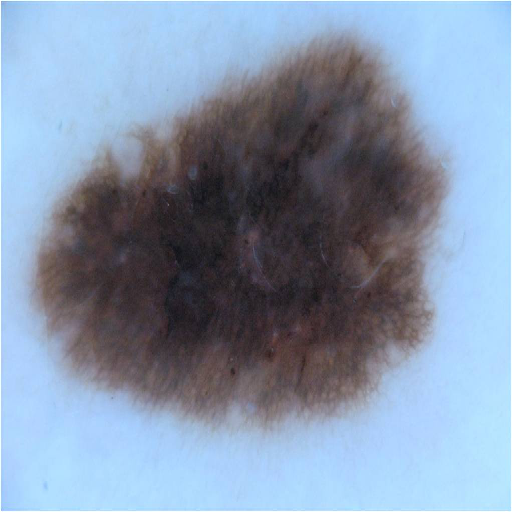

In [28]:
Image.fromarray(read_h5(list_names[0]))

In [31]:
for k in range(0,31,6):
    Image.fromarray(read_h5(list_names[k])).show()

In [21]:
for i in range(1,6):
    arr = read_h5(list_names[i])
    print(arr.shape, np.unique(arr))

(512, 512, 1) [-1]
(512, 512, 1) [-1]
(512, 512, 1) [-1]
(512, 512, 1) [-1  1]
(512, 512, 1) [-1]


In [37]:
masks = pd.read_csv('D:/Data/mask_ind.csv')
masks.head()

,globules,milia_like_cyst,negative_network,pigment_network,streaks
0,0,0,0,1,0
1,1,0,0,1,1
2,0,1,0,1,0
3,0,0,0,0,0
4,0,0,0,1,0


In [83]:
tv = pd.read_csv('D:/Data/train_test_id.csv')

In [38]:
for c in masks.columns:
    tv[c] = masks[c]

In [40]:
tv_ = pd.read_csv('D:/Data/train_test_id_.csv')

In [53]:
for id_ in tv.ID:
    row1 = tv[tv.ID == id_][['globules', 'milia_like_cyst', 'negative_network', 'pigment_network', 'streaks']].values[0]
    row2 = tv_[tv_.ID == id_][['globules', 'milia_like_cyst', 'negative_network', 'pigment_network', 'streaks']].values[0]
    assert (row1==row2).all()

In [55]:
tv.to_csv('D:/Data/train_test_id_with_masks.csv', index=False)

In [61]:
t = np.arange(2594)

In [64]:
np.random.shuffle(t)

In [68]:
print(t)

[1409 1960 1230 ... 1074 1562 2515]


In [97]:
import random
random.seed(1)
tv = pd.read_csv('D:/Data/train_test_id_with_masks.csv')
tv = tv.sample(frac=1, random_state=0).reset_index(drop=True)
print(len(tv.iloc[:1900]))
tv.loc[:1900,'Split'] = 'train'
tv.loc[1900:,'Split'] = 'valid'
tv.head()

1900


,ID,Split,globules,milia_like_cyst,negative_network,pigment_network,streaks
0,ISIC_0000203,train,0,0,1,1,0
1,ISIC_0014635,train,0,0,0,0,0
2,ISIC_0010862,train,0,0,0,0,0
3,ISIC_0014857,train,0,0,1,1,0
4,ISIC_0011220,train,1,0,0,0,0


In [98]:
tv.tail()

,ID,Split,globules,milia_like_cyst,negative_network,pigment_network,streaks
2589,ISIC_0011105,valid,1,1,0,1,0
2590,ISIC_0013617,valid,0,1,0,0,0
2591,ISIC_0010028,valid,0,0,0,1,0
2592,ISIC_0010206,valid,1,1,0,0,0
2593,ISIC_0013425,valid,0,0,1,0,0


In [104]:
sample = tv[tv['Split'] == 'train']
t = sample.ID.values
l = sample.loc[:,'globules':'streaks']

In [110]:
t.shape

(1900,)

In [105]:
t

array(['ISIC_0000203', 'ISIC_0014635', 'ISIC_0010862', ...,
       'ISIC_0014217', 'ISIC_0000495', 'ISIC_0000165'], dtype=object)

In [106]:
l

,globules,milia_like_cyst,negative_network,pigment_network,streaks
0,0,0,1,1,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,1,1,0
4,1,0,0,0,0
...,...,...,...,...,...
1895,1,0,0,0,0
1896,0,0,0,1,0
1897,0,1,0,1,0
1898,1,0,0,1,0


In [109]:
tv[tv.ID=='ISIC_0000165']

,ID,Split,globules,milia_like_cyst,negative_network,pigment_network,streaks
1899,ISIC_0000165,train,1,0,0,1,1


In [10]:
test = np.random.uniform(size=[2,2,3])
test

array([[[0.96050867, 0.34131312, 0.79399832],
        [0.91720497, 0.87030765, 0.91914969]],

       [[0.93226195, 0.82214809, 0.42555388],
        [0.71585938, 0.27696497, 0.11176023]]])

In [11]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
test2 = test - mean
test2

array([[[ 0.47550867, -0.11468688,  0.38799832],
        [ 0.43220497,  0.41430765,  0.51314969]],

       [[ 0.44726195,  0.36614809,  0.01955388],
        [ 0.23085938, -0.17903503, -0.29423977]]])

In [16]:
for row in test:
    for col in row:
        for i, ch in enumerate(col):
            print(ch-mean[i])

0.47550866987132245
-0.11468688448104641
0.3879983198080629
0.43220497439575367
0.4143076488063328
0.5131496897099227
0.44726195003019764
0.36614808918356717
0.019553883150002394
0.23085938441901332
-0.1790350261636932
-0.29423977446642047


In [18]:
test3 = test2 / std
test

array([[[0.96050867, 0.34131312, 0.79399832],
        [0.91720497, 0.87030765, 0.91914969]],

       [[0.93226195, 0.82214809, 0.42555388],
        [0.71585938, 0.27696497, 0.11176023]]])

In [19]:
for row in test2:
    for col in row:
        for i, ch in enumerate(col):
            print(ch / std[i])

2.076457073673897
-0.5119950200046715
1.7244369769247239
1.8873579667936842
1.8495877178854143
2.2806652875996565
1.953108952096933
1.6345896838552105
0.08690614733334397
1.0081195826157787
-0.7992635096593447
-1.3077323309618687


In [21]:
0.96050867 / 0.229

0.21995648543

In [52]:
import torchvision.transforms.functional as TF
test = torch.Tensor([[[0.96, 0.34, 0.79],
                      [0.91, 0.87, 0.92]],
                     [[0.93, 0.82, 0.42],
                      [0.71, 0.27, 0.11]]])
test = test.permute(-1, 0, 1)
print(test)
test.shape

tensor([[[0.9600, 0.9100],
         [0.9300, 0.7100]],

        [[0.3400, 0.8700],
         [0.8200, 0.2700]],

        [[0.7900, 0.9200],
         [0.4200, 0.1100]]])


torch.Size([3, 2, 2])

In [53]:
TF.normalize(test, mean, std)

tensor([[[ 2.0742,  1.8559],
         [ 1.9432,  0.9825]],

        [[-0.5179,  1.8482],
         [ 1.6250, -0.8304]],

        [[ 1.7067,  2.2844],
         [ 0.0622, -1.3156]]])

In [39]:
test_ = np.array([[[0.96, 0.34, 0.79],
[0.91, 0.87, 0.92]],
[[0.93, 0.82, 0.42],
[0.71, 0.27, 0.11]]])
(test_ - mean) / std

array([[[ 2.07423581, -0.51785714,  1.70666667],
        [ 1.8558952 ,  1.84821429,  2.28444444]],

       [[ 1.94323144,  1.625     ,  0.06222222],
        [ 0.98253275, -0.83035714, -1.31555556]]])

In [48]:
mean_t = torch.as_tensor(mean)
std_t = torch.as_tensor(std)
mean_t = mean_t[:, None, None]
print(mean_t)
print(mean_t.shape)
tensor.sub_(mean[:, None, None]).div_(std[:, None, None])

tensor([[[0.4850]],

        [[0.4560]],

        [[0.4060]]], dtype=torch.float64)
torch.Size([3, 1, 1])


NameError: name 'tensor' is not defined

In [108]:
r = random.Random(0)
print(r)
SEED_LIST = [r.randint(1, 500) for _ in range(10)]
SEED_LIST

[433, 198, 389, 456, 216, 21, 133, 495, 262, 249]

In [109]:
files = os.listdir('D:/Data/images/')
a = np.arange(len(files))
np.random.seed(SEED_LIST[0])
random.shuffle(a)

In [96]:
files = os.listdir('D:/Data/images/')
b = [(i,'a') for i in range(len(files))]
random.seed(SEED_LIST[0])
random.shuffle(b)

In [110]:
a

array([ 230, 2005,  380, ..., 1464,  500, 1279])

In [99]:
b

[(2403, 'a'),
 (1130, 'a'),
 (1186, 'a'),
 (1967, 'a'),
 (1529, 'a'),
 (531, 'a'),
 (516, 'a'),
 (613, 'a'),
 (182, 'a'),
 (488, 'a'),
 (2275, 'a'),
 (1795, 'a'),
 (395, 'a'),
 (368, 'a'),
 (2231, 'a'),
 (474, 'a'),
 (62, 'a'),
 (2310, 'a'),
 (2223, 'a'),
 (2113, 'a'),
 (866, 'a'),
 (875, 'a'),
 (1271, 'a'),
 (2307, 'a'),
 (2153, 'a'),
 (872, 'a'),
 (2134, 'a'),
 (1067, 'a'),
 (2567, 'a'),
 (391, 'a'),
 (2491, 'a'),
 (2415, 'a'),
 (1888, 'a'),
 (1109, 'a'),
 (268, 'a'),
 (458, 'a'),
 (1770, 'a'),
 (690, 'a'),
 (1318, 'a'),
 (1637, 'a'),
 (271, 'a'),
 (469, 'a'),
 (2350, 'a'),
 (638, 'a'),
 (2012, 'a'),
 (1932, 'a'),
 (1844, 'a'),
 (59, 'a'),
 (1823, 'a'),
 (369, 'a'),
 (930, 'a'),
 (1855, 'a'),
 (1293, 'a'),
 (723, 'a'),
 (826, 'a'),
 (1113, 'a'),
 (928, 'a'),
 (988, 'a'),
 (1190, 'a'),
 (2290, 'a'),
 (2506, 'a'),
 (2329, 'a'),
 (2330, 'a'),
 (1489, 'a'),
 (255, 'a'),
 (2054, 'a'),
 (774, 'a'),
 (43, 'a'),
 (1638, 'a'),
 (1845, 'a'),
 (101, 'a'),
 (2579, 'a'),
 (768, 'a'),
 (465, 'a'),

In [100]:
np.equal(a,b).all()

UFuncTypeError: ufunc 'equal' did not contain a loop with signature matching types (dtype('<U11'), dtype('<U11')) -> dtype('bool')

In [101]:
p = pd.DataFrame({'nums':np.arange(len(files))})

In [102]:
p

,nums
0,0
1,1
2,2
3,3
4,4
...,...
2589,2589
2590,2590
2591,2591
2592,2592


In [103]:
p = pd.read_csv('C:/Users/Admin/PycharmProjects/segmentation-as-additional-channels/Data/train_test_id_with_masks.csv')
print(p)
p.iloc[a]

                ID  Split  globules  milia_like_cyst  negative_network  \
0     ISIC_0000000  train         0                0                 0   
1     ISIC_0000001  train         1                0                 0   
2     ISIC_0000003  train         0                1                 0   
3     ISIC_0000004  train         0                0                 0   
4     ISIC_0000006  train         0                0                 0   
...            ...    ...       ...              ...               ...   
2589  ISIC_0016068  valid         0                0                 0   
2590  ISIC_0016069  train         1                0                 0   
2591  ISIC_0016070  train         0                1                 0   
2592  ISIC_0016071  train         0                0                 0   
2593  ISIC_0016072  train         0                0                 0   

      pigment_network  streaks  
0                   1        0  
1                   1        1  
2           

,ID,Split,globules,milia_like_cyst,negative_network,pigment_network,streaks
2403,ISIC_0015264,train,1,0,0,0,0
1130,ISIC_0011339,train,0,0,0,1,0
1186,ISIC_0012143,valid,0,0,0,0,0
1967,ISIC_0014299,train,0,0,0,0,0
1529,ISIC_0013128,train,0,1,0,1,0
...,...,...,...,...,...,...,...
2006,ISIC_0014434,train,0,0,0,1,0
165,ISIC_0000184,valid,1,0,0,1,0
308,ISIC_0000358,train,0,0,1,1,0
2035,ISIC_0014525,valid,1,0,0,0,0


In [116]:
import sklearn.metrics as m
m.recall_score([0,1.,1], np.around([0,1.,0.59999999]))

1.0